In [4]:
#Always run when just opening notebook
!pip install librosa

pyasn1-modules 0.2.1 has requirement pyasn1<0.5.0,>=0.4.1, but you'll have pyasn1 0.1.9 which is incompatible.
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.


In [3]:
import matplotlib.pyplot as plt
import warnings
import six
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import numpy as np

def get_window(window, Nx, fftbins=True):
    if six.callable(window):
        return window(Nx)

    elif (isinstance(window, (six.string_types, tuple)) or
          np.isscalar(window)):
        # TODO: if we add custom window functions in librosa, call them here

        return scipy.signal.get_window(window, Nx, fftbins=fftbins)

    elif isinstance(window, (np.ndarray, list)):
        if len(window) == Nx:
            return np.asarray(window)

        raise ParameterError('Window size mismatch: '
                             '{:d} != {:d}'.format(len(window), Nx))
    else:
        raise ParameterError('Invalid window specification: {}'.format(window))

def stft(y, n_fft=2048, hop_length=None, win_length=None, window='hann', center=True, dtype=np.complex64, pad_mode='reflect'):
    # By default, use the entire frame
    if win_length is None:
        win_length = n_fft

    # Set the default hop, if it's not already specified
    if hop_length is None:
        hop_length = int(win_length // 4)

    fft_window = get_window(window, win_length, fftbins=True)

    # Pad the window out to n_fft size
    fft_window = util.pad_center(fft_window, n_fft)

    # Reshape so that the window can be broadcast
    fft_window = fft_window.reshape((-1, 1))

    # Check audio is valid
    util.valid_audio(y)

    # Pad the time series so that frames are centered
    if center:
        y = np.pad(y, int(n_fft // 2), mode=pad_mode)

    # Window the time series.
    y_frames = util.frame(y, frame_length=n_fft, hop_length=hop_length)

    # Pre-allocate the STFT matrix
    stft_matrix = np.empty((int(1 + n_fft // 2), y_frames.shape[1]),
                           dtype=dtype,
                           order='F')

    # how many columns can we fit within MAX_MEM_BLOCK?
    n_columns = int(util.MAX_MEM_BLOCK / (stft_matrix.shape[0] *
                                          stft_matrix.itemsize))

    for bl_s in range(0, stft_matrix.shape[1], n_columns):
        bl_t = min(bl_s + n_columns, stft_matrix.shape[1])

        # RFFT and Conjugate here to match phase from DPWE code
        stft_matrix[:, bl_s:bl_t] = fft.fft(fft_window *
                                            y_frames[:, bl_s:bl_t],
                                            axis=0)[:stft_matrix.shape[0]]

    return stft_matrix

def fft_frequencies(sr=22050, n_fft=2048):
    return np.linspace(0,
                       float(sr) / 2,
                       int(1 + n_fft//2),
                       endpoint=True)

def mel_frequencies(n_mels=128, fmin=0.0, fmax=11025.0, htk=False):
    # 'Center freqs' of mel bands - uniformly spaced between limits
    min_mel = hz_to_mel(fmin, htk=htk)
    max_mel = hz_to_mel(fmax, htk=htk)

    mels = np.linspace(min_mel, max_mel, n_mels)

    return mel_to_hz(mels, htk=htk)

def _spectrogram(y=None, S=None, n_fft=2048, hop_length=512, power=1):
    if S is not None:
        # Infer n_fft from spectrogram shape
        n_fft = 2 * (S.shape[0] - 1)
    else:
        # Otherwise, compute a magnitude spectrogram from input
        S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length))**power

    return S, n_fft

def mel(sr, n_fft, n_mels=128, fmin=0.0, fmax=None, htk=False, norm=1):
    if fmax is None:
        fmax = float(sr) / 2

    if norm is not None and norm != 1 and norm != np.inf:
        raise ParameterError('Unsupported norm: {}'.format(repr(norm)))

    # Initialize the weights
    n_mels = int(n_mels)
    weights = np.zeros((n_mels, int(1 + n_fft // 2)))

    # Center freqs of each FFT bin
    fftfreqs = fft_frequencies(sr=sr, n_fft=n_fft)

    # 'Center freqs' of mel bands - uniformly spaced between limits
    mel_f = mel_frequencies(n_mels + 2, fmin=fmin, fmax=fmax, htk=htk)

    fdiff = np.diff(mel_f)
    ramps = np.subtract.outer(mel_f, fftfreqs)

    for i in range(n_mels):
        # lower and upper slopes for all bins
        lower = -ramps[i] / fdiff[i]
        upper = ramps[i+2] / fdiff[i+1]

        # .. then intersect them with each other and zero
        weights[i] = np.maximum(0, np.minimum(lower, upper))

    if norm == 1:
        # Slaney-style mel is scaled to be approx constant energy per channel
        enorm = 2.0 / (mel_f[2:n_mels+2] - mel_f[:n_mels])
        weights *= enorm[:, np.newaxis]

    # Only check weights if f_mel[0] is positive
    if not np.all((mel_f[:-2] == 0) | (weights.max(axis=1) > 0)):
        # This means we have an empty channel somewhere
        warnings.warn('Empty filters detected in mel frequency basis. '
                      'Some channels will produce empty responses. '
                      'Try increasing your sampling rate (and fmax) or '
                      'reducing n_mels.')

    return weights

def melspectrogram(y=None, sr=22050, S=None, n_fft=2048, hop_length=512, power=2.0, **kwargs):
    S, n_fft = _spectrogram(y=y, S=S, n_fft=n_fft, hop_length=hop_length,
                            power=power)

    # Build a Mel filter
    mel_basis = mel(sr, n_fft, **kwargs)

    return np.dot(mel_basis, S)

Sample rate:  44100
Audio raw array:  [-24. -44. -24. ...   0.   0.   0.]
Shape of spectrogram:  (128, 4052)
Raw spectrogram:  [[2.88610791e+05 1.86503601e+06 2.61269730e+06 ... 1.65884233e+07
  6.29952436e+05 2.53220474e+03]
 [2.71384815e+06 5.96743597e+06 6.97921889e+06 ... 1.72786429e+07
  9.74892062e+05 7.81395890e+03]
 [6.95190605e+05 3.56319557e+06 3.27659517e+06 ... 1.76424798e+06
  3.02508224e+05 5.12923086e+03]
 ...
 [2.31442395e+01 9.00809220e+00 4.42948090e+00 ... 3.25246659e+00
  2.84100266e+00 1.91867824e+00]
 [1.29611402e+01 5.82501235e+00 4.34428613e+00 ... 3.24914612e+00
  2.79508357e+00 2.12736847e+00]
 [1.64117730e+01 6.12885250e+00 2.68823759e+00 ... 2.53556220e+00
  2.41418066e+00 2.11722503e+00]]


'print(sample_rate)\nprint(samples)\nchannel1 = samples[ : , 0]\nprint(channel1)\nprint(channel1.size)\n\nplt.pcolormesh(times, frequencies, spectrogram)\n\nplt.imshow(spectrogram, aspect="auto")\nplt.gca().invert_yaxis()\nplt.ylabel(\'Frequency\')\nplt.xlabel(\'Time\')\nplt.figure(figsize=(10,10))\nplt.show()'

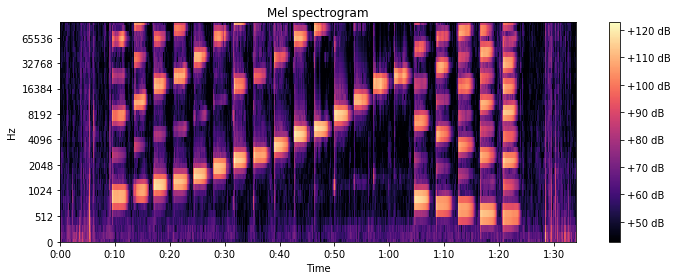

In [18]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
import numpy as np

sample_rate, samples = wavfile.read('audio/homeFloor.wav')
#samples = samples[44100*5 : 44100*15, 0]
samples = samples[:,0]
samples = samples.astype(np.floating)
print("Sample rate: ", sample_rate)
print("Audio raw array: ", samples)
spectrogram = librosa.feature.melspectrogram(samples, sample_rate)
print("Shape of spectrogram: ", spectrogram.shape)
print("Raw spectrogram: ", spectrogram)
spectrogram = spectrogram[ : 40, :]

plt.figure(figsize=(10, 4))
#librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), y_axis='mel', fmax=100000, x_axis='time')
librosa.display.specshow(librosa.power_to_db(spectrogram), y_axis='mel', fmax=100000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

"""print(sample_rate)
print(samples)
channel1 = samples[ : , 0]
print(channel1)
print(channel1.size)

plt.pcolormesh(times, frequencies, spectrogram)

plt.imshow(spectrogram, aspect="auto")
plt.gca().invert_yaxis()
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.figure(figsize=(10,10))
plt.show()"""

In [3]:
import numpy as np
import soundfile as sf

data, fs = sf.read("audio/homeFloor.wav", dtype="float32")
print(data)
print(data.size)


[[-0.00073242 -0.00073242]
 [-0.00134277 -0.00134277]
 [-0.00073242 -0.00073242]
 ...
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
4149120
